##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [17]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [18]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [19]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [20]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [21]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [22]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [23]:
df.head() # few rows of data

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


### Explain what each column of data means

- X: The longitude coordinate of the crime scene. Longitude is a geographic coordinate that specifies the east-west position of a point on the Earth's surface. 

- Y: The latitude coordinate of the crime incident. Latitude is a geographic coordinate that specifies the north-south position of a point on the Earth's surface. 

- Area_Command: A categorical identifier for various police operational areas or jurisdictions. Within the operational structure of the police department, each unique number represents a specific area command. 

- NIBRSOffenseCode: This is the crime's National Incident-Based Reporting System (NIBRS) code. According to the NIBRS classification, each code corresponds to a different type of offense.

- DayOfWeek: This categorical variable denotes the weekday on which the offense was recorded. It's encoded as a series of digits ranging from 0 to 6, with each number representing a different day, beginning with Monday (0) and ending with Sunday (6).

- Time: On a 24-hour clock, this denotes the hour during which the occurrence was reported. When looking at patterns or trends in crime, this data might be useful since some crimes may be more likely to occur at specific times of day or night.

- VictimCount: This is the project's target variable. It reflects the number of victims involved in the crime incidence.

### Identify the input and target variables

- `Input variables (features)`: 'X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', and 'Time'. These are the features that model learns from.

- `Target variable (label)`: 'VictimCount' column. Our model will predict.

In [24]:
#  Range of values in each column: Minimum and Maximum values of each column.

# df.min() - can be used to find the minimum.
# df.max() - can be used to find the maximum.
df.describe()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,-115.159326,36.143360,3.978182,0.909091,2.981818,11.236364,0.712727
std,0.101294,0.118418,3.045799,0.334878,1.924590,7.039937,0.978427
min,-116.000000,35.068419,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-115.209198,36.114704,1.000000,1.000000,1.000000,5.000000,0.000000
50%,-115.149945,36.152415,3.000000,1.000000,3.000000,11.000000,0.000000
75%,-115.105200,36.183854,6.000000,1.000000,5.000000,18.000000,1.000000
max,-114.625570,37.000000,11.000000,2.000000,6.000000,23.000000,6.000000


### Do you need to scale, shift or normalize your data?

- Distinct Scales: The 'X' and 'Y' columns have a different scale than the other columns. These attributes have ranges of about -116 to -114 and 35 to 37, respectively, although other feature columns have lower ranges. Larger-scale characteristics might significantly influence the model's learning process, biasing it towards these features.

- Standardization: If we employ a neural network, standardizing our input characteristics is advantageous. When input characteristics are on a comparable size, neural networks frequently converge faster and perform better, especially when optimization techniques like gradient descent are used. Another scaling approach is standardization, in which the values are centered around the mean and have a single standard deviation. As a result, the attribute's mean becomes zero, and the resulting distribution has a unit standard deviation.

- Given these points, you should standardize your data, especially the 'X' and 'Y' columns. 

References - https://towardsdatascience.com/what-is-feature-scaling-why-is-it-important-in-machine-learning-2854ae877048
https://atoti.io/articles/when-to-perform-a-feature-scaling/
https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [25]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class CrimeDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return [self.features[idx], self.targets[idx]]

# Splitting the dataset into training and testing sets
target = df['VictimCount'].values
features = df.drop('VictimCount', axis=1).values

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42)  # 80% training, 20% testing
# Code Reference -  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

# We should scale our features ('X' and 'Y' specifically)
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

# Converting to PyTorch tensors
features_train = torch.tensor(features_train, dtype=torch.float32)
target_train = torch.tensor(target_train, dtype=torch.float32).view(-1, 1)
features_test = torch.tensor(features_test, dtype=torch.float32)
target_test = torch.tensor(target_test, dtype=torch.float32).view(-1, 1)

# Creating custom datasets
train_dataset = CrimeDataset(features=features_train, targets=target_train)
test_dataset = CrimeDataset(features=features_test, targets=target_test)
# Code Reference -  https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset

# Creating data loaders
batch_size = 32  # You can adjust this number based on your system's capabilities

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Code Reference - https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

# Verifying the shape of the batched data
for batch_features, batch_targets in train_loader:
    print(f"Batch features shape: {batch_features.shape}")
    print(f"Batch targets shape: {batch_targets.shape}")
    break  # We only need to check the shape of one batch


Batch features shape: torch.Size([32, 6])
Batch targets shape: torch.Size([32, 1])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

a) Define the proper loss function for this task.
 - In the context of a regression problem, where we predict a continuous value (number of crime victims), the Mean Squared Error (MSE) loss function is appropriate.
 - The MSELoss calculates the mean of the squared differences between the predicted and actual values, effectively quantifying the difference between the two sets of numbers.
 References - https://en.wikipedia.org/wiki/Mean_squared_error

b) What should the size of the predicted output be?
 - The predicted output should be a single continuous value representing the number of crime victims. This is evident in the design of the neural network, where the final layer outputs a single value:
 - self.fc4 = nn.Linear(8, 1)  # The output is a single value
  References - https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33

c) Explain your choice of architecture, including how many layers you will be using
 - I've designed a deep neural network with multiple layers (four linear layers).
 - The first layer (fc1) takes the input features and transforms them through 32 units, a choice that allows the network to learn a higher-dimensional representation of the input.
 - Two more hidden layers (fc2 and fc3) help the network learn more complex representations by increasing the depth. They have 16 and 8 units, respectively, gradually narrowing the network to prepare for the final prediction.
 - The ReLU activation function is used, which allows the network to learn non-linear relationships efficiently and is less susceptible to the vanishing gradient problem.
 - The final layer (fc4) is a linear layer with one unit, used for predicting the continuous target variable.
 - This architecture represents a balanced approach, increasing the model's capacity to learn from the data without making it too complex.
   References -https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9
   https://www.v7labs.com/blog/neural-network-architectures-guide
   https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7

d) Define an optimizer for training this model, choose a proper learning rate
 - The code uses the Adam optimizer, known for its effectiveness and efficiency.
 - optimizer = optim.Adam(model.parameters(), lr=0.001)
 - The learning rate is set at 0.0001, a sensible starting point. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.
 References - https://www.jeremyjordan.me/nn-learning-rate/

e) Training loop
 - Training loop includes both the forward pass (calculating the output and loss) and the backward pass (backpropagating errors and adjusting weights).
 - I've separated the training and evaluation phases, preventing data leakage and ensuring that the model doesn't learn from the test set.
 References - https://www.jeremyjordan.me/nn-learning-rate/

In [57]:
import torch.nn as nn
import torch.optim as optim

# Define the model to match the provided example
class CrimePredictor(nn.Module):
    def __init__(self):
        super(CrimePredictor, self).__init__()
        # Adjusting the layer sizes and removing dropout to match the example
        self.fc1 = nn.Linear(6, 32)  # input features: 6, output: 20
        self.fc2 = nn.Linear(32, 16)  # input: 20, output: 10
        self.fc3 = nn.Linear(16, 8)  # input: 10, output: 5
        self.fc4 = nn.Linear(8, 1)  # output: 1, matching the example

        self.relu = nn.ReLU()  # Using ReLU activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Removed dropout
        x = self.relu(self.fc2(x))  # Removed dropout
        x = self.relu(self.fc3(x))  # Removed dropout
        x = self.fc4(x)  
        return x

# Initialize the model
model = CrimePredictor()

# Define the loss function (MSE for regression)
criterion = nn.MSELoss()

# Adjust the learning rate to match the example
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Adjust the number of epochs to match the example
num_epochs = 100  # This is adjustable based on the example's performance
for epoch in range(num_epochs):
    model.train()  # Explicitly setting the training mode
    # Training loop
    for features, targets in train_loader:
        optimizer.zero_grad()
        output = model(features) # Forward pass
        loss = criterion(output, targets)
        loss.backward() # Backward pass
        optimizer.step()

    # Test loop - to match the example's structure for loss calculation
    model.eval()  # Evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for features, targets in test_loader:
            output = model(features)
            loss = criterion(output, targets)
            total_loss += loss.item()  # Summing up the loss

    # Calculating average loss
    avg_mse = total_loss / len(test_loader)  # Average MSE
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test MSE Loss: {avg_mse:.4f}')

# https://machinelearningmastery.com/building-a-regression-model-in-pytorch/

Epoch [1/100], Test MSE Loss: 1.8121
Epoch [2/100], Test MSE Loss: 1.8033
Epoch [3/100], Test MSE Loss: 1.7943
Epoch [4/100], Test MSE Loss: 1.7852
Epoch [5/100], Test MSE Loss: 1.7760
Epoch [6/100], Test MSE Loss: 1.7664
Epoch [7/100], Test MSE Loss: 1.7568
Epoch [8/100], Test MSE Loss: 1.7469
Epoch [9/100], Test MSE Loss: 1.7370
Epoch [10/100], Test MSE Loss: 1.7269
Epoch [11/100], Test MSE Loss: 1.7169
Epoch [12/100], Test MSE Loss: 1.7061
Epoch [13/100], Test MSE Loss: 1.6951
Epoch [14/100], Test MSE Loss: 1.6838
Epoch [15/100], Test MSE Loss: 1.6723
Epoch [16/100], Test MSE Loss: 1.6607
Epoch [17/100], Test MSE Loss: 1.6489
Epoch [18/100], Test MSE Loss: 1.6365
Epoch [19/100], Test MSE Loss: 1.6240
Epoch [20/100], Test MSE Loss: 1.6109
Epoch [21/100], Test MSE Loss: 1.5978
Epoch [22/100], Test MSE Loss: 1.5842
Epoch [23/100], Test MSE Loss: 1.5704
Epoch [24/100], Test MSE Loss: 1.5564
Epoch [25/100], Test MSE Loss: 1.5426
Epoch [26/100], Test MSE Loss: 1.5284
Epoch [27/100], Test 

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

a) How would you find the number of classes on the output data?
- I have used num_classes = df['VictimCount'].nunique() to find the number of distinct classes in the 'VictimCount' column. This method counts all unique values, thereby determining the number of different classes. 
 References: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nunique.html

b) How is the architecture different? 
- Task 3 (Regression): The model ends with a single output neuron because it predicts a single continuous value. There is no activation function like softmax or sigmoid at the end, which are typically used in classification to represent probability distributions over classes.

- Task 4 (Classification): The architecture involves an output layer with a number of neurons equal to the number of classes, with a softmax function typically applied to the output to obtain a probability distribution. This is necessary for multi-class classification.

c) How is the loss function different?
- Task 3: Uses Mean Squared Error (MSE) loss because it's a regression task aiming to minimize the squared differences between the predicted continuous values and the actual targets.

- Task 4: Uses Cross-Entropy Loss, suitable for classification tasks. It quantifies the difference between two probability distributions - the predictions (output of the model) and the targets (actual labels).

In [77]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

num_classes = df['VictimCount'].nunique()

# Define the model
class CrimeClassifier(nn.Module):
    def __init__(self):
        super(CrimeClassifier, self).__init__()
        self.fc1 = nn.Linear(6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, num_classes)

        self.soft = nn.Softmax() # Using Softmax activation function

    def forward(self, x):
        x = self.soft(self.fc1(x))
        x = self.soft(self.fc2(x))
        x = self.soft(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
model = CrimeClassifier()

# Define the loss function (CrossEntropyLoss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate is adjustable

# Training loop
num_epochs = 70 # Number of epochs is adjustable
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0
    correct_train = 0
    total_train = 0

    # Training step
    for features, targets in train_loader:
        targets = targets.long()
        optimizer.zero_grad()  # Clear previous gradients
        output = model(features)  # Forward pass
        loss = criterion(output, targets.squeeze())  # Compute loss; ensure targets are not one-hot encoded
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item() * features.size(0)  # Multiply by batch size

        # Calculate training accuracy
        _, predicted = torch.max(output.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets.squeeze()).sum().item()

    # Evaluation step
    model.eval()  # Set model to evaluation mode
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for features, targets in test_loader:
            output = model(features)
            probs = F.softmax(output, dim=1)
            _, predicted = torch.max(probs.data, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets.squeeze()).sum().item()

    # Calculate average losses and accuracy
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    test_accuracy = 100 * correct_test / total_test

    print(f"Epoch: {epoch+1}/{num_epochs}.. "
          f"Test Accuracy: {test_accuracy:.3f}%")
    
    #https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html



Epoch: 1/70.. Test Accuracy: 54.545%
Epoch: 2/70.. Test Accuracy: 54.545%
Epoch: 3/70.. Test Accuracy: 54.545%
Epoch: 4/70.. Test Accuracy: 54.545%
Epoch: 5/70.. Test Accuracy: 54.545%
Epoch: 6/70.. Test Accuracy: 54.545%
Epoch: 7/70.. Test Accuracy: 54.545%
Epoch: 8/70.. Test Accuracy: 54.545%
Epoch: 9/70.. Test Accuracy: 54.545%
Epoch: 10/70.. Test Accuracy: 54.545%
Epoch: 11/70.. Test Accuracy: 54.545%
Epoch: 12/70.. Test Accuracy: 54.545%
Epoch: 13/70.. Test Accuracy: 54.545%
Epoch: 14/70.. Test Accuracy: 54.545%
Epoch: 15/70.. Test Accuracy: 54.545%
Epoch: 16/70.. Test Accuracy: 54.545%
Epoch: 17/70.. Test Accuracy: 54.545%
Epoch: 18/70.. Test Accuracy: 54.545%
Epoch: 19/70.. Test Accuracy: 54.545%
Epoch: 20/70.. Test Accuracy: 54.545%
Epoch: 21/70.. Test Accuracy: 54.545%
Epoch: 22/70.. Test Accuracy: 54.545%
Epoch: 23/70.. Test Accuracy: 54.545%
Epoch: 24/70.. Test Accuracy: 54.545%
Epoch: 25/70.. Test Accuracy: 54.545%
Epoch: 26/70.. Test Accuracy: 54.545%
Epoch: 27/70.. Test A

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

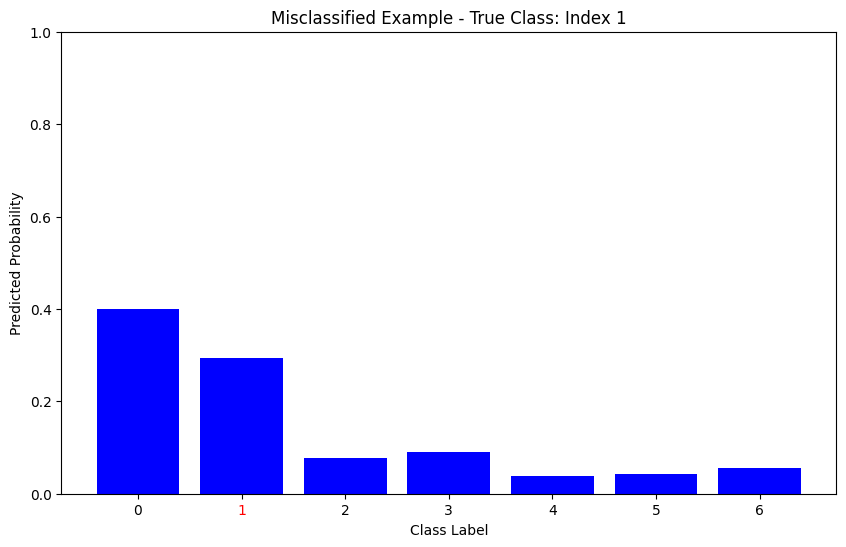

In [78]:
import matplotlib.pyplot as plt

# Function to find a misclassified example, predict probabilities, and plot results
def plot_misclassified_example(model, test_loader):
    model.eval()
    misclassified_examples = []

    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)  # Get model predictions
            probs = F.softmax(outputs, dim=1)  # Apply softmax to get probabilities
            _, predictions = torch.max(probs, 1)  # Get the predicted classes

            # Check for any misclassifications
            mismatch = (predictions != targets.squeeze()).nonzero(as_tuple=False).squeeze()
            if mismatch.numel():  # If there are any misclassifications
                mismatch = mismatch[0]  # Get the first misclassified example
                correct_class = targets.squeeze()[mismatch].item()
                misclassified_examples.append((features[mismatch], probs[mismatch], correct_class))
                break  # We break after finding the first misclassification

    # If a misclassified example is found, we plot it
    if misclassified_examples:
        example, probabilities, true_class = misclassified_examples[0]
        true_class = int(true_class)  # Ensure true_class is an integer


        # Convert the probabilities to a format suitable for plotting
        probabilities = probabilities.cpu().numpy()  # Move to cpu and convert to numpy array

        # Create a bar chart
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(probabilities)), probabilities, color='blue')
        plt.xlabel('Class Label')
        plt.ylabel('Predicted Probability')
        plt.title(f'Misclassified Example - True Class: Index {true_class}')
        plt.xticks(range(len(probabilities)))
        plt.ylim([0, 1])

        # Highlight the true class
        plt.gca().get_xticklabels()[true_class].set_color('red')

        plt.show()
    else:
        print("No misclassified example found in the provided batch.")

# Now, we call the function to plot a misclassified example
plot_misclassified_example(model, test_loader)



- During tasks 3 and 4, we applied deep learning to predict crime victim counts, first as a continuous variable (regression) and then as categories (classification).

- In Task 3, the regression model improved slowly and consistently, most likely due to predicting in a continuous space, which allowed for progressive tweaks. The focus was on lowering prediction error, as assessed by Mean Squared Error (MSE).

- The regression model, on the other hand, demonstrated a more consistent learning trajectory, indicating that it was efficiently exploiting the dataset's attributes for predictive insights. The classification model's standstill at 54.545% might point to problems such as class imbalance, inadequate model complexity, or a need for improved feature engineering.

- Overall, the regression model outperformed the classification model, demonstrating progressive and consistent learning, whereas the classification model immediately approached a performance limit, highlighting potential limitations in its ability to generalize or capture complex dataset features.

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


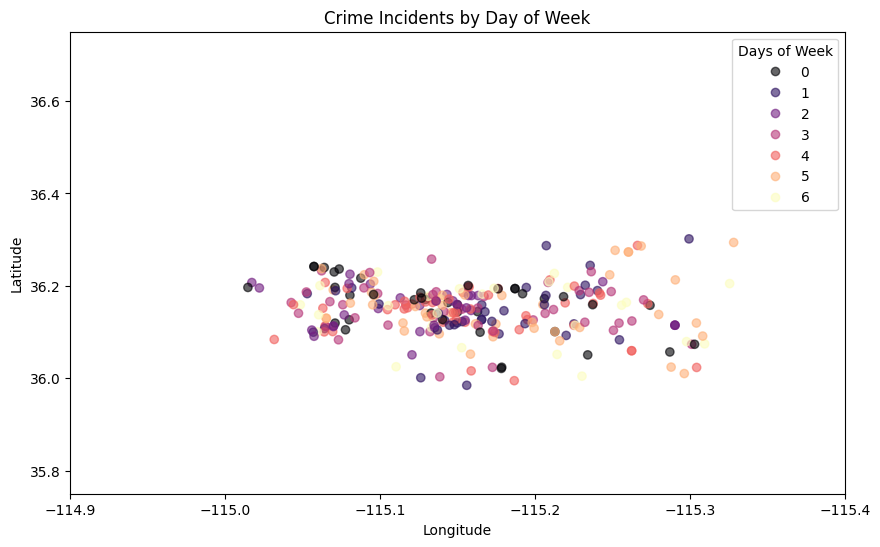

In [82]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the 'DayOfWeek' column is categorical so we can easily color by this property
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'])

# Create a scatter plot, coloring by day of the week
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'].cat.codes, cmap='magma', alpha=0.6)

# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), loc="upper right", title="Days of Week")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Crime Incidents by Day of Week')
plt.xlim(-114.9, -115.4) # Zoomed in the output area to find patterns.
plt.ylim(35.75, 36.75)  # if outlier information is important then comment out this both lines of code
plt.show()

- At first look, the incidences appear to be distributed similarly over different days of the week. The colors appear to be uniformly spread around the region, implying that the number of incidences does not vary greatly from day to day. There seem to be no significant pattern.

- Incident Concentration: Despite the uniform distribution of occurrences throughout the days, there are apparent concentrations of incidents in specific places in Las vegas. These clusters imply that there are 'hot zones' in which occurrences are more likely to occur, regardless of the day of the week. It is critical to identify these areas for resource allocation and strategic planning in crime prevention.

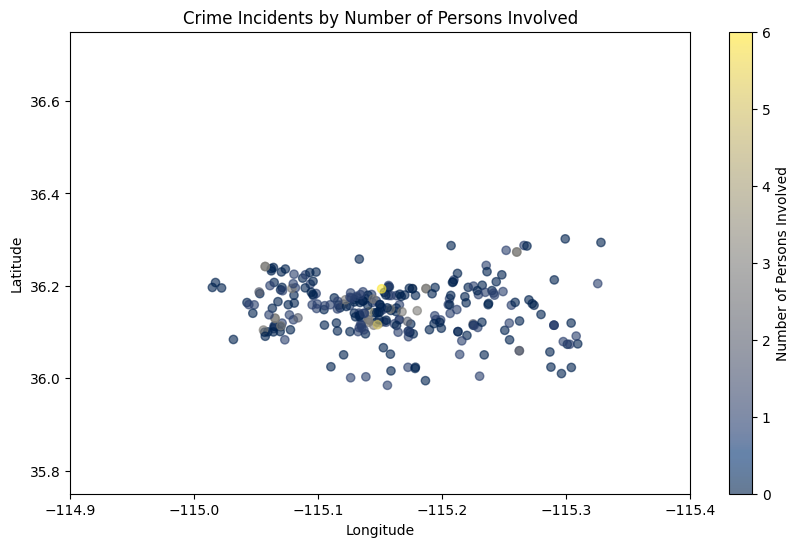

In [83]:
import matplotlib.pyplot as plt

# Ensure the 'VictimCount' column is numerical
df['VictimCount'] = pd.to_numeric(df['VictimCount'])

# Create a scatter plot, coloring by the number of victims involved
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='cividis', alpha=0.6)

# Create a colorbar to show the victim count
colorbar = plt.colorbar()
colorbar.set_label('Number of Persons Involved')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Crime Incidents by Number of Persons Involved')
plt.xlim(-114.9, -115.4) # Zoomed in the output area to find patterns.
plt.ylim(35.75, 36.75)  # if outlier information is important then comment out this both lines of code
plt.show()


- Darker Points Predominate: The bulk of the points on the map are darker, implying that most incidences involve fewer people. This pattern may imply that crimes with several victims are less prevalent. Crimes with multiple victims is very low and can be viewed in the graph to be very rarely appearing.

In [31]:
crime_counts = df['DayOfWeek'].value_counts()

sorted_crime_counts = crime_counts.sort_index()

print(sorted_crime_counts)


DayOfWeek
0    40
1    37
2    32
3    44
4    51
5    43
6    28
Name: count, dtype: int64


- Day 4 had the largest number of recorded incidences, with 51 documented instances. This conclusion may be consistent with the belief that criminal activity increases during the weekend, potentially due to increased social activities, gatherings, or other characteristics peculiar to this time of year.